In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import matplotlib.pyplot as plt
from torchvision.transforms import v2
import torch
from torch.utils.data import DataLoader
import numpy as np
import gc
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
import src.transforms as custom_transform
import src.models.models as models
import src.data.dataloaders as dl

print(os.getcwd())



c:\Users\tobia\anaconda3\envs\vertexsrc_rnd\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


c:\Users\tobia\Documenter\Master\38103_XTech\vertexsrc_rnd\notebooks


1625 1080


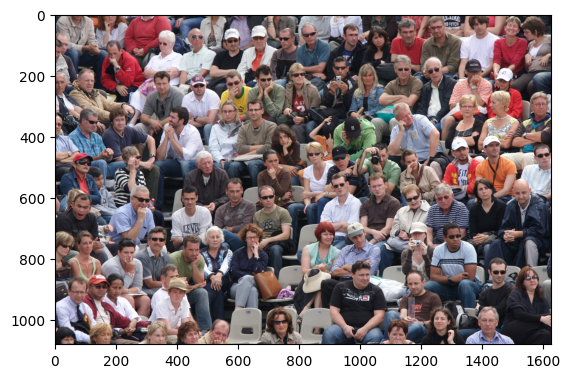

In [4]:
model, image_processor = models.YOLOS()
from PIL import Image

#img = Image.open("../data/interim/pexels-kaique-rocha-109919.jpg")
img = Image.open("../data/interim/Dark/img_1103.jpg")
#img = img.resize((int(img.width/4), int(img.height/4)), Image.Resampling.LANCZOS)
print(img.width, img.height)
plt.imshow(img)

In [29]:
transforms = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((512, 1024))
])
transformed_img = transforms(img)[None, :]
outputs = model(transformed_img)

In [30]:
logits = outputs.logits
bboxes = outputs.pred_boxes

target_sizes = torch.tensor([transformed_img.size()[:1:-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

Detected person with confidence 0.902 at location [228.38, 370.04, 295.37, 745.8]
Detected person with confidence 0.995 at location [294.3, 413.2, 373.03, 862.09]
Detected person with confidence 0.911 at location [105.76, 412.96, 166.43, 769.27]
Detected person with confidence 0.976 at location [243.13, 379.0, 345.06, 887.63]
Detected person with confidence 0.955 at location [346.32, 417.63, 386.19, 512.31]
Detected person with confidence 0.996 at location [176.55, 409.65, 264.78, 964.27]
Detected person with confidence 0.991 at location [45.22, 339.52, 166.0, 888.8]
Detected person with confidence 0.995 at location [388.5, 458.25, 487.88, 940.05]
Detected person with confidence 0.928 at location [389.12, 415.6, 426.39, 507.45]
Detected person with confidence 0.973 at location [462.66, 421.65, 511.9, 896.51]
Detected person with confidence 0.99 at location [352.65, 449.5, 419.43, 831.8]


In [2]:
standard = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((512, 1024))
])
color_jitter = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((512, 1024)),
    v2.ColorJitter(brightness=(1.1, 1.2))
])
custom = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((512, 1024))
])
test_transforms = {}
test_transforms['standard'] = [standard]
#test_transforms['color_jitter'] = [color_jitter]
#test_transforms['custom'] = [custom]

In [9]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device}")
model, image_processor = models.YOLOS()
model = model.to(device)
results_dict = {}
for transforms in test_transforms.keys():
    print(f"using following transform: \n{transforms}")
    dataset = dl.DarkTestDataset("..\\data\\interim\\Dark", transforms=test_transforms[transforms])
    log_dict = {}
    predictions = []
    accuracy = []
    for img, points in dataset:
        outputs = model(img[None, :].to(device))
        logits = outputs.logits
        bboxes = outputs.pred_boxes

        target_sizes = torch.tensor([img.size()[1:]])
        results = image_processor.post_process_object_detection(outputs, threshold=0.8, target_sizes=target_sizes)[0]
        
        predictions.append(len([x for x in results['labels'] if x == 1]))
        accuracy.append(round(predictions[-1]/len(points+1e-5)*100.0, 3))
        
        print(f"Prediction: {len(results['scores'])} people, Ground truth: {len(points)} people ({accuracy[-1]}%)")
        print(f"Average confidence: {torch.mean(results['scores'])}", end="\n\n")
    log_dict['num_predict'] = predictions
    log_dict['acc'] = accuracy
    results_dict[transforms] = log_dict
    


using cuda
using following transform: 
Compose(
      ToImage()
      ToDtype(scale=True)
      Resize(size=[512, 1024], interpolation=InterpolationMode.BILINEAR, antialias=True)
)
Prediction: 8 people, Ground truth: 696 people (1.149%)
Average confidence: 0.8612688779830933

Prediction: 7 people, Ground truth: 175 people (4.0%)
Average confidence: 0.861433744430542

Prediction: 7 people, Ground truth: 267 people (1.873%)
Average confidence: 0.903407871723175

Prediction: 4 people, Ground truth: 121 people (3.306%)
Average confidence: 0.8611747026443481

Prediction: 5 people, Ground truth: 512 people (0.977%)
Average confidence: 0.8852635622024536

Prediction: 6 people, Ground truth: 284 people (2.113%)
Average confidence: 0.8721937537193298

Prediction: 7 people, Ground truth: 166 people (4.217%)
Average confidence: 0.8215898871421814

Prediction: 11 people, Ground truth: 388 people (2.835%)
Average confidence: 0.8728612065315247

Prediction: 1 people, Ground truth: 962 people (0.104%

In [3]:
results_dict["standard"]

NameError: name 'results_dict' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


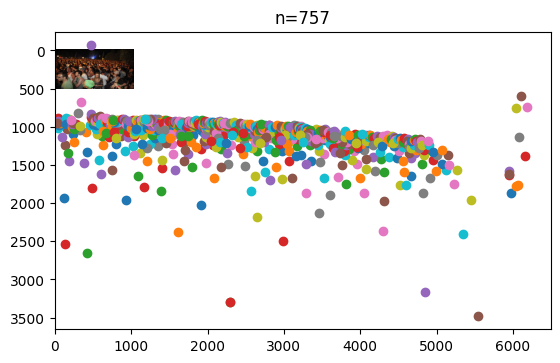

In [4]:
img, points = dataset[0]
plt.figure()
plt.imshow(img.permute(1,2,0))
for point in points:
    plt.plot(point[0], point[1], 'o')
plt.title(f"n={len(points)}")
plt.show()

In [25]:
for img, _ in dataset:
    print(img.shape)

torch.Size([3, 1325, 1987])
torch.Size([3, 688, 1024])
torch.Size([3, 1177, 1772])
torch.Size([3, 1936, 2592])
torch.Size([3, 1065, 1600])
torch.Size([3, 2448, 3264])
torch.Size([3, 900, 1200])
torch.Size([3, 1333, 2000])
torch.Size([3, 2304, 3456])
torch.Size([3, 960, 1440])
torch.Size([3, 1137, 2000])
torch.Size([3, 3744, 5616])
torch.Size([3, 2848, 4288])
torch.Size([3, 3744, 5616])
torch.Size([3, 2592, 3872])
torch.Size([3, 3456, 5184])
